# Contrastive Learning Experiment Notebook

Train algorithms on increasing dataset sizes and plot risk/likelihood.

## Setup

Environment, imports, device selection, and reproducibility seeds.

In [1]:
# Imports and path setup
import sys
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# Add project root to path if needed (before importing project modules)
sys.path.append(str(Path('..').resolve()))

from source.dataset import datasets
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm
from source.utils import hparams_registry

# Select device: use GPU if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Reproducibility
seed = int(os.environ.get('SEED', 0))
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(seed)
print(f'Using seed: {seed}')

/home/mila/t/tom.marty/invariant_bench/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Using seed: 0


In [2]:
import logging

from source.utils.misc import group_counts, build_group_index, w, safe_mean, InfiniteDataLoader, find_timestamp_root
print("Utility functions for robust error handling loaded successfully.")

Utility functions for robust error handling loaded successfully.


## Experiment configuration

Dataset choice, learners, and result containers.

In [3]:
DEBUG = False

# Experiment config
DATA_PATH = os.path.expanduser('~/scratch/invariant_bench/data/benchmark')

DATASET_NAME = 'CMNIST'
NETWORK_NAME = 'mnist_cnn'  # 'resnet', 'simple_mlp', or 'mnist_cnn'
BATCH_SIZE = 128
NUM_FIT = 7 # number of points in the PCL curve
NUM_WORKERS = 0

USE_STRATIFIED = True # Toggle: use stratified (label, attr) sampling such that the class ratio is preserved
ROBUST_TRAINING = True  # Enable     robust error handling
MAX_RETRIES = 3  # Maximum number of retries for failed operations
CONTINUE_ON_ERROR = True  # Continue with next algorithm/size if current fails
SAVE_PARTIAL_RESULTS = True  # Save results even if some experiments fail

# Early stopping configuration
ES_MIN_DELTA = 0
ES_PATIENCE = 3         # checkpoints without improvement before stopping


print('Config:')
print(f'  Dataset: {DATASET_NAME}')
print(f'  Data path: {DATA_PATH}')
print(f'  Stratified sampling: {USE_STRATIFIED}')
print(f'  Debug mode: {DEBUG}')

# Prepare per-learner results storage
val_loss_map = []           # validation loss means (best)
train_loss_map = []         # training loss mean (per size)
test_loss_map  = []         # test loss means (final model)


Config:
  Dataset: CMNIST
  Data path: /home/mila/t/tom.marty/scratch/invariant_bench/data/benchmark
  Stratified sampling: True
  Debug mode: False


## Hyperparameters

Defaults and dataset-specific overrides.

In [4]:
# Hyperparameters template
import os
from source.utils.misc import safe_float_env

# We'll derive specific hparams per learner in the training loop
base_hparams = hparams_registry.default_hparams('ERM', DATASET_NAME)
base_hparams['image_arch'] = NETWORK_NAME

if NETWORK_NAME == 'resnet':
    base_hparams.update({
        'pretrained': False,
        'input_size': 224
    })
elif NETWORK_NAME == 'simple_mlp' or NETWORK_NAME == 'mnist_cnn':
    base_hparams.update({
        'input_size': 28, 
        'lr': 1e-3,
    })


#TODO check that pretrained=FALSE for ResNet works
"""
Colored MNIST specific hyperparameters:
- cmnist_label_prob: Probability of label imbalance (default 0.5)
- cmnist_attr_prob: Probability of attribute imbalance (default 0.5)
- cmnist_spur_prob: Controls the summed diagonal proportion (0,1). The more this is towards 0, the more the color is spuriously correlated with the label. 
"""

cmnist_label_prob = safe_float_env("CMNIST_LABEL_PROB", 0.5)
cmnist_attr_prob = safe_float_env("CMNIST_ATTR_PROB", 0.5)
cmnist_spur_prob = safe_float_env("CMNIST_SPUR_PROB", 0.1)

if DATASET_NAME == 'CMNIST':
    base_hparams.update({
        'cmnist_label_prob': cmnist_label_prob,
        'cmnist_attr_prob': cmnist_attr_prob, 
        'cmnist_spur_prob': cmnist_spur_prob,
        'cmnist_flip_prob': 0.0,
    })


## Datasets

Load train/val/test splits and preview samples.

Datasets:
  Train size: 30000 | Val size: 10000 | Test size: 20000 (restricted)
  Input shape: (3, 28, 28) | data_type: images
  num_labels: 2 | num_attributes: 2
Stratified groups (counts): {(0, 0): 13849, (0, 1): 1482, (1, 0): 1480, (1, 1): 13189}

Class distribution:
       count  percentage
class                   
0      15331        51.1
1      14669        48.9

Attribute distribution:
           count  percentage
attribute                   
0          15329        51.1
1          14671        48.9

Group (class, attribute) distribution:
                 count  percentage
class attribute                   
0     0          13849       46.16
      1           1482        4.94
1     0           1480        4.93
      1          13189       43.96


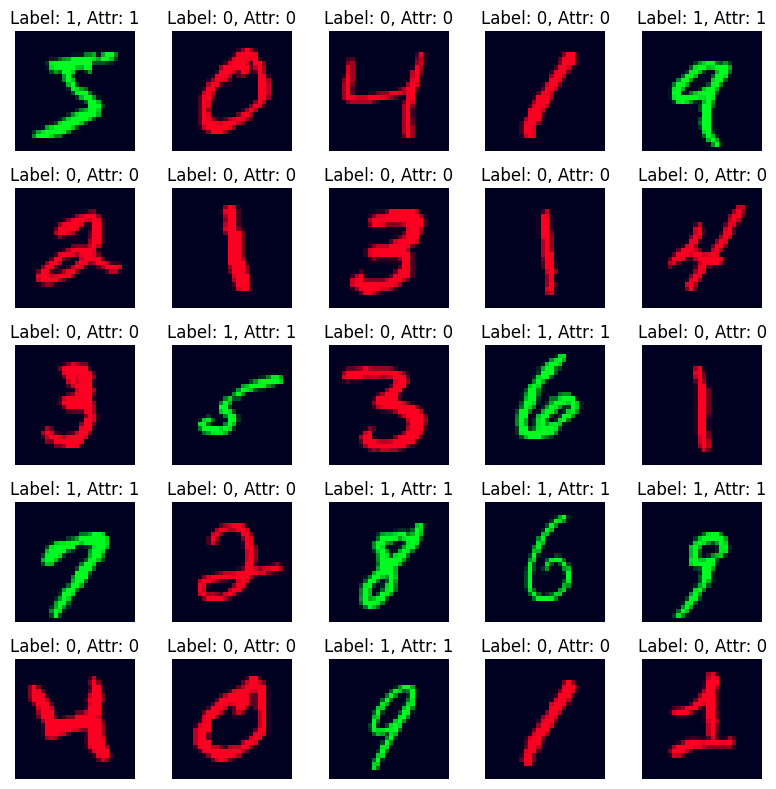

In [5]:
# Attach key attributes to Subset objects for easier access
def attach_dataset_attributes(subset):
    """ Attach key attributes from the underlying dataset to a Subset object."""
    if hasattr(subset, 'dataset'):
        for attr in ['INPUT_SHAPE', 'num_labels', 'num_attributes', 'data_type']:
            if hasattr(subset.dataset, attr):
                setattr(subset, attr, getattr(subset.dataset, attr))


# Create a perfectly balanced test dataset (all probabilities set to 0.5)
balanced_test_hparams = base_hparams.copy()
balanced_test_hparams.update({
    'cmnist_label_prob': 0.5,
    'cmnist_attr_prob': 0.5,
    'cmnist_spur_prob': 0.5,
    'cmnist_flip_prob': 0.0
})

DatasetClass = getattr(datasets, DATASET_NAME)
train_dataset = DatasetClass(DATA_PATH, 'tr', base_hparams)
val_dataset = DatasetClass(DATA_PATH, 'va', base_hparams)
test_dataset = DatasetClass(DATA_PATH, 'te', balanced_test_hparams)

# If debug, reduce all datasets to size 100
if DEBUG:
    train_indices = random.sample(range(len(train_dataset)), min(100, len(train_dataset)))
    val_indices = random.sample(range(len(val_dataset)), min(100, len(val_dataset)))
    test_indices = random.sample(range(len(test_dataset)), min(100, len(test_dataset)))
    train_dataset = Subset(train_dataset, train_indices)
    val_dataset = Subset(val_dataset, val_indices)
    test_dataset = Subset(test_dataset, test_indices)
    dataset_sizes = [10, 100]
else:
    max_train_size = len(train_dataset)
    dataset_sizes = np.logspace(1, np.log10(max_train_size), num=NUM_FIT, dtype=int).tolist()

    
attach_dataset_attributes(train_dataset)
attach_dataset_attributes(val_dataset)
attach_dataset_attributes(test_dataset)

indices = list(range(len(train_dataset)))
random.shuffle(indices)

input_shape = train_dataset.INPUT_SHAPE
num_labels = train_dataset.num_labels
num_attributes = train_dataset.num_attributes
data_type = getattr(train_dataset, 'data_type', 'images')

print('Datasets:')
print(f'  Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)} (restricted)')
print(f'  Input shape: {input_shape} | data_type: {data_type}')
print(f'  num_labels: {num_labels} | num_attributes: {num_attributes}')

    
if USE_STRATIFIED:
    group_to_indices = build_group_index(train_dataset)
    group_counts_dict = {k: len(v) for k, v in sorted(group_to_indices.items())}
    print('Stratified groups (counts):', group_counts_dict)

    # Aggregate counts for each class and attribute
    import pandas as pd
    import numpy as np
    df = pd.DataFrame([{'class': k[0], 'attribute': k[1], 'count': v} for k, v in group_counts_dict.items()])
    class_counts = df.groupby('class')['count'].sum()
    attr_counts = df.groupby('attribute')['count'].sum()
    total = df['count'].sum()

    print('\nClass distribution:')
    class_dist = df.groupby('class')['count'].sum().to_frame()
    class_dist['percentage'] = (class_dist['count'] / total * 100).round(2)
    print(class_dist.to_string())

    print('\nAttribute distribution:')
    attr_dist = df.groupby('attribute')['count'].sum().to_frame()
    attr_dist['percentage'] = (attr_dist['count'] / total * 100).round(2)
    print(attr_dist.to_string())

    print('\nGroup (class, attribute) distribution:')
    group_dist = df.set_index(['class','attribute'])
    group_dist['percentage'] = (group_dist['count'] / total * 100).round(2)
    print(group_dist.to_string())
    
# Preview a few samples (images only)
if data_type == 'images':
    fig, axes = plt.subplots(5, 5, figsize=(8, 8))
    axes = axes.flatten()

    for k, ax in enumerate(axes):
        idx, x, y, a, _ = train_dataset[k]
        # Scale per-image to [0,1] for visualization
        x_vis = x.detach().cpu()
        x_min, x_max = x_vis.min(), x_vis.max()
        x_vis = (x_vis - x_min) / (x_max - x_min + 1e-6)
        ax.imshow(x_vis.permute(1, 2, 0))
        ax.set_title(f'Label: {int(y)}, Attr: {int(a)}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('Non-image dataset preview omitted.')

## Training and evaluation

Main training loop over dataset sizes and algorithms with robust error handling.

In [ ]:
import os
import math
import time
import itertools
import gc
import torch
from source.learning.algorithms import VAE

# Use environment variable for timestamp if set, else fallback to current time
base_timestamp = os.environ.get('RESULT_FOLDER', time.strftime('%Y%m%d-%H%M%S'))

result_dir = os.path.join("../results", base_timestamp)
os.makedirs(result_dir, exist_ok=True)

log_file = os.path.join(result_dir, 'training.log')
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Enhanced error tracking
ERROR_LOG = {
    'size_failures': {},
    'step_failures': {},
    'validation_failures': {},
    'test_failures': {}
}

# Function to clear GPU memory
def clear_gpu_memory():
    """Clear GPU memory and run garbage collection"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

# Function to convert tensor to float (detach from GPU)
def tensor_to_float(tensor_val):
    """Convert tensor to float, detaching from GPU memory"""
    if isinstance(tensor_val, dict):
        return {k: tensor_to_float(v) for k, v in tensor_val.items()}
    elif hasattr(tensor_val, 'item'):
        return tensor_val.detach().cpu().item()
    elif hasattr(tensor_val, 'detach'):
        return tensor_val.detach().cpu().numpy()
    else:
        return float(tensor_val)

# Precompute subsets for each dataset size
subset_indices_map = {}
for size in dataset_sizes:
    if USE_STRATIFIED:
        subset_indices = w(group_to_indices, size, rng=np.random.RandomState(0 + size))
        subset_indices_map[size] = subset_indices
    else:
        subset_indices = random.sample(indices, min(size, len(indices)))
        subset_indices_map[size] = subset_indices

# Initialize tracking
hparams = base_hparams.copy()

val_loss_map = [float('nan')] * len(dataset_sizes)
train_loss_map = [float('nan')] * len(dataset_sizes)
test_loss_map = [float('nan')] * len(dataset_sizes)

print(f"Training on dataset sizes: {dataset_sizes}")

for idx, size in enumerate(dataset_sizes):
    print(f"\n--- Training with size={size} ---")
    

    clear_gpu_memory()
    
    subset_indices = subset_indices_map[size]
    train_subset = Subset(train_dataset, subset_indices)
    attach_dataset_attributes(train_subset)

    input_shape = train_subset.INPUT_SHAPE
    num_labels = train_subset.num_labels
    num_attributes = train_subset.num_attributes
    data_type = getattr(train_subset, 'data_type', 'images')
    hparams = hparams_registry.default_hparams("VAE", DATASET_NAME)
    hparams.update(base_hparams)
    
    learner = VAE(data_type, input_shape, num_labels, num_attributes, len(train_subset), hparams)
    if hasattr(learner, 'to'):
        learner = learner.to(DEVICE)

    print(f"[Init] size={size} | data_type={data_type} | input_shape={input_shape} | labels={num_labels} | attrs={num_attributes} | stratified={USE_STRATIFIED}")
    print(f"GPU memory after model creation: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

    checkpoint_freq = max(20, math.ceil(len(train_subset) / BATCH_SIZE))
    best_val = float('inf')
    bad_checks = 0

    # Include spur_prob in checkpoint names
    spur_prob_str = str(cmnist_spur_prob).replace('.', 'p')
    
    # Get the root timestamp directory for saving checkpoints
    timestamp_root = find_timestamp_root(result_dir)
    featurizer_path = os.path.join(timestamp_root, 'checkpoints', f'featurizer_size{size}_spur{spur_prob_str}.pt')
    os.makedirs(os.path.dirname(featurizer_path), exist_ok=True)
    vae_path = os.path.join(timestamp_root, 'checkpoints', 'VAE', f'vae_size{size}_spur{spur_prob_str}.pt')
    os.makedirs(os.path.dirname(vae_path), exist_ok=True)
    train_losses_epoch = []
    learner.train()

    train_minibatches_iterator = iter(InfiniteDataLoader(
        train_subset, None, BATCH_SIZE, NUM_WORKERS
    ))
    
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    pbar = tqdm(itertools.count(), desc=f"Train size={size}", leave=False)
    for step in pbar:
        try:
            # Get next training batch - now includes digit value
            i, x, y, a, digit = next(train_minibatches_iterator)
            x, y, a = x.to(DEVICE), y.to(DEVICE), a.to(DEVICE)

            cur_loss = learner.update((i, x, y, a), step)
            
            # Convert loss to float immediately to free GPU memory
            cur_loss_float = tensor_to_float(cur_loss)
            train_losses_epoch.append(cur_loss_float)
            
            do_check = (
                step > 0 and
                (step % checkpoint_freq == 0 or step == 1000)  # Check at regular intervals
            )
            
            if do_check:
                # Compute validation loss - now handles digit value
                learner.eval()
                val_losses_step = []
                
                with torch.no_grad():  # Important: disable gradients during validation
                    for i_val, x_val, y_val, a_val, digit_val in val_loader:
                        x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)
                        _, loss = learner.predict(x_val, y_val, return_loss=True)
                        # Convert to float immediately and move to CPU
                        val_losses_step.append(tensor_to_float(loss))
                        
                learner.train()
                
                mean_val_loss = sum(val_losses_step) / len(val_losses_step)
                
                improved = mean_val_loss < (best_val - ES_MIN_DELTA)
                if improved:
                    best_val = mean_val_loss
                    bad_checks = 0
                    torch.save(learner.featurizer.state_dict(), featurizer_path)
                    torch.save(learner.state_dict(), vae_path)
                else:
                    bad_checks += 1

                # Extract loss value from dictionary for display
                cur_loss_val = cur_loss_float.get("loss", 0.0) if isinstance(cur_loss_float, dict) else cur_loss_float
                pbar.set_description(f"Train size={size} | step={step} | train_loss={cur_loss_val:.3f} | val_loss={mean_val_loss:.3f} | bad_checks={bad_checks}/{ES_PATIENCE}")
                
                # Clear validation losses from memory
                del val_losses_step
                
                if bad_checks >= ES_PATIENCE:
                    print(f"Early stopping at step {step}")
                    break

        except Exception as e:
            if ROBUST_TRAINING:
                print(f"Error at step {step}: {e}")
                ERROR_LOG['step_failures'][f'size_{size}_step_{step}'] = str(e)
                if CONTINUE_ON_ERROR:
                    continue
                else:
                    break
            else:
                raise e

    pbar.close()
    
    # Load best model and compute final metrics
    try:
        learner.load_state_dict(torch.load(vae_path))
        learner.eval()
        
        # Validation loss
        val_losses = []
        with torch.no_grad():
            for i_val, x_val, y_val, a_val, digit_val in val_loader:
                x_val, y_val, a_val = x_val.to(DEVICE), y_val.to(DEVICE), a_val.to(DEVICE)
                _, loss = learner.predict(x_val, y_val, return_loss=True)
                val_losses.append(tensor_to_float(loss))
        val_loss = sum(val_losses) / len(val_losses)
        val_loss_map[idx] = val_loss
        del val_losses  # Clear from memory
        
        # Test loss  
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
        test_losses = []
        with torch.no_grad():
            for i_test, x_test, y_test, a_test, digit_test in test_loader:
                x_test, y_test, a_test = x_test.to(DEVICE), y_test.to(DEVICE), a_test.to(DEVICE)
                _, loss = learner.predict(x_test, y_test, return_loss=True)
                test_losses.append(tensor_to_float(loss))
        test_loss = sum(test_losses) / len(test_losses)
        test_loss_map[idx] = test_loss
        del test_losses  # Clear from memory
        
        # Training loss (from last epoch) - now working with floats
        recent_losses = train_losses_epoch[-min(len(train_losses_epoch), 10):]
        if isinstance(recent_losses[0], dict):
            train_loss_map[idx] = sum([loss.get("loss", 0.0) for loss in recent_losses]) / len(recent_losses)
        else:
            train_loss_map[idx] = sum(recent_losses) / len(recent_losses)
        
        print(f"[Final] size={size} | train_loss={train_loss_map[idx]:.4f} | val_loss={val_loss:.4f} | test_loss={test_loss:.4f}")
        logger.info(f"Completed size={size} | train_loss={train_loss_map[idx]:.4f} | val_loss={val_loss:.4f} | test_loss={test_loss:.4f}")
        
    except Exception as e:
        if ROBUST_TRAINING:
            print(f"Error in evaluation for size {size}: {e}")
            ERROR_LOG['validation_failures'][f'size_{size}'] = str(e)
        else:
            raise e

Training on dataset sizes: [10, 37, 144, 547, 2080, 7899, 30000]

--- Training with size=10 ---
[Init] size=10 | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True
GPU memory after model creation: 0.00 GB


Early stopping at step 160
[Final] size=10 | train_loss=4561.5406 | val_loss=78693.8678 | test_loss=81493.2373

--- Training with size=37 ---
[Init] size=37 | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True
GPU memory after model creation: 0.02 GB


Early stopping at step 120
[Final] size=37 | train_loss=18141.0273 | val_loss=72408.5201 | test_loss=73659.6827

--- Training with size=144 ---
[Init] size=144 | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True
GPU memory after model creation: 0.02 GB


Early stopping at step 400
[Final] size=144 | train_loss=37416.7668 | val_loss=66747.5196 | test_loss=68939.9374

--- Training with size=547 ---
[Init] size=547 | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True
GPU memory after model creation: 0.02 GB


Early stopping at step 240
[Final] size=547 | train_loss=57762.0266 | val_loss=66970.7026 | test_loss=68357.7061

--- Training with size=2080 ---
[Init] size=2080 | data_type=images | input_shape=(3, 28, 28) | labels=2 | attrs=2 | stratified=True
GPU memory after model creation: 0.02 GB


Train size=2080 | step=980 | train_loss=51258.320 | val_loss=52077.690 | bad_checks=0/3: : 993it [00:31, 36.07it/s]

In [ ]:
# Multi-Checkpoint Analysis: PCA and UMAP Visualization Function
import os
import glob
import numpy as np
from sklearn.decomposition import PCA
import umap
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import torch
from source.learning.algorithms import VAE

def analyze_checkpoints_folder(checkpoint_folder, eval_dataset, comparison_name="Checkpoint Comparison"):
    """
    Load multiple VAE checkpoints and generate PCA and UMAP visualizations for each.
    
    Args:
        checkpoint_folder (str): Path to folder containing .pt checkpoint files
        eval_dataset: Dataset to extract embeddings from
        comparison_name (str): Name for the comparison plots
    """
    
    # Find all .pt files in the folder
    checkpoint_files = glob.glob(os.path.join(checkpoint_folder, "*.pt"))
    
    if not checkpoint_files:
        print(f"No .pt checkpoint files found in {checkpoint_folder}")
        return
    
    # Sort checkpoints by training size (extract number from filename like vae_size547.pt)
    def extract_size_from_filename(filepath):
        filename = os.path.basename(filepath)
        # Look for pattern like "size123" in filename
        import re
        match = re.search(r'size(\d+)', filename)
        if match:
            return int(match.group(1))
        else:
            # Fallback to alphabetical sorting if no size found
            return 0
    
    checkpoint_files.sort(key=extract_size_from_filename)
    print(f"Found {len(checkpoint_files)} checkpoint files (sorted by training size):")
    for i, file in enumerate(checkpoint_files):
        size = extract_size_from_filename(file)
        print(f"  {i+1}: {os.path.basename(file)} (size: {size})")
    
    # Prepare evaluation dataset
    eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    # Store results for all checkpoints
    all_embeddings = []
    all_labels = []
    all_attrs = []
    all_digits = []
    all_reconstructions = []  # Store reconstructions for visualization
    all_original_samples = []  # Store original samples for reconstruction comparison
    checkpoint_names = []
    
    for checkpoint_path in checkpoint_files:
        checkpoint_name = os.path.basename(checkpoint_path).replace('.pt', '')
        training_size = extract_size_from_filename(checkpoint_path)
        display_name = f"Size {training_size}" if training_size > 0 else checkpoint_name
        checkpoint_names.append(display_name)
        
        try:
            
            # Create a new learner instance (using correct parameter names)
            # Get the current hyperparameters to use
            current_hparams = hparams if 'hparams' in globals() else base_hparams
            
            temp_learner = VAE(
                data_type=getattr(eval_dataset, 'data_type', 'images'),
                input_shape=eval_dataset.INPUT_SHAPE,
                num_classes=eval_dataset.num_labels,  # VAE expects num_classes, not num_labels
                num_attributes=eval_dataset.num_attributes,
                num_examples=len(eval_dataset),
                hparams=current_hparams
            )
            
            # Load checkpoint
            temp_learner.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
            temp_learner = temp_learner.to(DEVICE)
            temp_learner.eval()
            
            # Extract embeddings
            embeddings_list = []
            labels_list = []
            attrs_list = []
            digits_list = []
            
            # Get 3 samples for reconstruction visualization
            sample_originals = []
            sample_reconstructions = []
            sample_labels = []
            sample_attrs = []
            sample_digits = []
            
            with torch.no_grad():
                for batch_idx, (i_batch, x_batch, y_batch, a_batch, digit_batch) in enumerate(eval_loader):
                    x_batch = x_batch.to(DEVICE)
                    
                    features = temp_learner.featurizer(x_batch)

                    # Move to CPU and convert to numpy
                    embeddings_list.append(features.cpu().numpy())
                    labels_list.append(y_batch.numpy())
                    attrs_list.append(a_batch.numpy())
                    digits_list.append(digit_batch.numpy())
                    
                    # Collect first 3 samples for reconstruction visualization
                    if batch_idx == 0 and len(sample_originals) < 3:
                        # Get reconstructions for the first 3 samples
                        n_samples_to_get = min(3, len(x_batch))
                        x_samples = x_batch[:n_samples_to_get]
                        
                        # Encode and decode
                        mu, logvar = temp_learner.encode(x_samples)
                        reconstructed = temp_learner.decode(mu)  # Use mean reconstruction
                        
                        # Store samples
                        sample_originals.extend([x_samples[i].cpu() for i in range(n_samples_to_get)])
                        sample_reconstructions.extend([reconstructed[i].cpu() for i in range(n_samples_to_get)])
                        sample_labels.extend([y_batch[i].item() for i in range(n_samples_to_get)])
                        sample_attrs.extend([a_batch[i].item() for i in range(n_samples_to_get)])
                        sample_digits.extend([digit_batch[i].item() for i in range(n_samples_to_get)])
            
            # Concatenate all batches
            embeddings = np.concatenate(embeddings_list, axis=0)
            labels = np.concatenate(labels_list, axis=0)
            attrs = np.concatenate(attrs_list, axis=0)
            digits = np.concatenate(digits_list, axis=0)
            
            all_embeddings.append(embeddings)
            all_labels.append(labels)
            all_attrs.append(attrs)
            all_digits.append(digits)
            all_reconstructions.append(sample_reconstructions)
            all_original_samples.append(sample_originals)
            

            # Clean up
            del temp_learner
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
            
        except Exception as e:
            print(f"  Error processing {checkpoint_name}: {e}")
            continue
    
    if not all_embeddings:
        print("No checkpoints were successfully processed.")
        return
    
    # Create comparison plots
    n_checkpoints = len(all_embeddings)
    
    # Reconstruction Visualization
    print(f"\n=== Reconstruction Comparison for {n_checkpoints} checkpoints ===")
    
    # Function to normalize images for display
    def normalize_for_display(img_tensor):
        img = img_tensor.clone()
        img_min, img_max = img.min(), img.max()
        if img_max > img_min:
            img = (img - img_min) / (img_max - img_min)
        return img
    
    # Create reconstruction comparison plot
    fig_recon, axes_recon = plt.subplots(2, n_checkpoints * 3, figsize=(4*n_checkpoints, 8))
    if n_checkpoints == 1:
        axes_recon = axes_recon.reshape(2, 3)
    
    for checkpoint_idx, (originals, reconstructions, name) in enumerate(zip(all_original_samples, all_reconstructions, checkpoint_names)):
        for sample_idx in range(min(3, len(originals))):
            col_idx = checkpoint_idx * 3 + sample_idx
            
            # Original image
            orig_img = originals[sample_idx]
            if orig_img.shape[0] == 1:  # Grayscale
                axes_recon[0, col_idx].imshow(orig_img.squeeze(), cmap='gray')
            else:  # RGB
                axes_recon[0, col_idx].imshow(orig_img.permute(1, 2, 0))
            
            if sample_idx == 1:  # Middle sample gets the checkpoint name
                axes_recon[0, col_idx].set_title(f'{name}\nOriginal', fontsize=10)
            else:
                axes_recon[0, col_idx].set_title('Original', fontsize=10)
            axes_recon[0, col_idx].axis('off')
            
            # Reconstructed image
            recon_img = reconstructions[sample_idx]
            if recon_img.shape[0] == 1:  # Grayscale
                axes_recon[1, col_idx].imshow(recon_img.squeeze(), cmap='gray')
            else:  # RGB
                axes_recon[1, col_idx].imshow(recon_img.permute(1, 2, 0))
            
            if sample_idx == 1:  # Middle sample gets the checkpoint name
                axes_recon[1, col_idx].set_title(f'{name}\nReconstructed', fontsize=10)
            else:
                axes_recon[1, col_idx].set_title('Reconstructed', fontsize=10)
            axes_recon[1, col_idx].axis('off')
    
    plt.suptitle(f'{comparison_name} - Reconstruction Comparison (3 samples per checkpoint)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # PCA Analysis
    print(f"\n=== PCA Analysis for {n_checkpoints} checkpoints ===")
    
    fig_pca, axes_pca = plt.subplots(2, n_checkpoints, figsize=(6*n_checkpoints, 12))
    if n_checkpoints == 1:
        axes_pca = axes_pca.reshape(2, 1)
    
    for i, (embeddings, labels, attrs, digits, name) in enumerate(zip(all_embeddings, all_labels, all_attrs, all_digits, checkpoint_names)):
        # Apply PCA
        pca = PCA(n_components=3)
        embeddings_pca = pca.fit_transform(embeddings)
        embeddings_2d = embeddings_pca[:, [0, 1]]  # Use PC1 and PC2
        # Plot 1: Colored by attributes
        unique_attrs = np.unique(attrs)
        colors_attrs = plt.cm.Set1(np.linspace(0, 1, len(unique_attrs)))
        
        for j, attr in enumerate(unique_attrs):
            mask = attrs == attr
            axes_pca[0, i].scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                                 c=[colors_attrs[j]], label=f'Attr {int(attr)}', alpha=0.6, s=15)
        
        axes_pca[0, i].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        axes_pca[0, i].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        axes_pca[0, i].set_title(f'{name}\nPCA - Colored by Attribute')
        axes_pca[0, i].legend(fontsize=8)
        axes_pca[0, i].grid(True, alpha=0.3)
        
        # Plot 2: Colored by digits
        unique_digits = np.unique(digits)
        colors_digits = plt.cm.tab10(np.linspace(0, 1, len(unique_digits)))
        
        for j, digit in enumerate(unique_digits):
            mask = digits == digit
            axes_pca[1, i].scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                                 c=[colors_digits[j]], label=f'Digit {int(digit)}', alpha=0.6, s=15)
        
        axes_pca[1, i].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        axes_pca[1, i].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        axes_pca[1, i].set_title(f'{name}\nPCA - Colored by Digit')
        axes_pca[1, i].legend(fontsize=8)
        axes_pca[1, i].grid(True, alpha=0.3)
    
    plt.suptitle(f'{comparison_name} - PCA Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # UMAP Analysis
    print(f"\n=== UMAP Analysis for {n_checkpoints} checkpoints ===")
    
    fig_umap, axes_umap = plt.subplots(2, n_checkpoints, figsize=(6*n_checkpoints, 12))
    if n_checkpoints == 1:
        axes_umap = axes_umap.reshape(2, 1)
    
    for i, (embeddings, labels, attrs, digits, name) in enumerate(zip(all_embeddings, all_labels, all_attrs, all_digits, checkpoint_names)):
        # Subsample for UMAP if needed
        max_samples = 3000
        if len(embeddings) > max_samples:
            indices = np.random.choice(len(embeddings), max_samples, replace=False)
            embeddings_subset = embeddings[indices]
            attrs_subset = attrs[indices]
            digits_subset = digits[indices]
        else:
            embeddings_subset = embeddings
            attrs_subset = attrs
            digits_subset = digits
        
        # Apply UMAP
        # Use appropriate parameters for UMAP
        n_neighbors = min(15, max(2, len(embeddings_subset)//10))
        umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=n_neighbors, min_dist=0.1, verbose=False, n_jobs=1)
        embeddings_2d = umap_reducer.fit_transform(embeddings_subset)
        
        # Plot 1: Colored by attributes
        unique_attrs = np.unique(attrs_subset)
        colors_attrs = plt.cm.Set1(np.linspace(0, 1, len(unique_attrs)))
        
        for j, attr in enumerate(unique_attrs):
            mask = attrs_subset == attr
            axes_umap[0, i].scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                                  c=[colors_attrs[j]], label=f'Attr {int(attr)}', alpha=0.6, s=15)
        
        axes_umap[0, i].set_xlabel('UMAP Dimension 1')
        axes_umap[0, i].set_ylabel('UMAP Dimension 2')
        axes_umap[0, i].set_title(f'{name}\nUMAP - Colored by Attribute')
        axes_umap[0, i].legend(fontsize=8)
        axes_umap[0, i].grid(True, alpha=0.3)
        
        # Plot 2: Colored by digits
        unique_digits = np.unique(digits_subset)
        colors_digits = plt.cm.tab10(np.linspace(0, 1, len(unique_digits)))
        
        for j, digit in enumerate(unique_digits):
            mask = digits_subset == digit
            axes_umap[1, i].scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                                  c=[colors_digits[j]], label=f'Digit {int(digit)}', alpha=0.6, s=15)
        
        axes_umap[1, i].set_xlabel('UMAP Dimension 1')
        axes_umap[1, i].set_ylabel('UMAP Dimension 2')
        axes_umap[1, i].set_title(f'{name}\nUMAP - Colored by Digit')
        axes_umap[1, i].legend(fontsize=8)
        axes_umap[1, i].grid(True, alpha=0.3)

    plt.suptitle(f'{comparison_name} - UMAP Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"\nAnalysis complete for {n_checkpoints} checkpoints!")

In [ ]:
# Call the analysis function to visualize checkpoint performance
# Ensure the `timestamp_root` variable is set from the training cell above.
# This path should point to the folder where your VAE checkpoints are saved.


checkpoint_folder_path = os.path.join(timestamp_root, 'checkpoints', 'VAE')
#or modify to your own local folder


if os.path.exists(checkpoint_folder_path):
    analyze_checkpoints_folder(
        checkpoint_folder=checkpoint_folder_path, 
        eval_dataset=test_dataset, 
        comparison_name=f"VAE Analysis (spur={cmnist_spur_prob})"
    )
else:
    print(f"Checkpoint folder not found, skipping analysis: {checkpoint_folder_path}")
    print("Please ensure that the training process has completed and generated checkpoints.")

Found 35 checkpoint files (sorted by training size):
  1: featurizer_size10_spur0p05.pt (size: 10)
  2: featurizer_size10_spur0p1.pt (size: 10)
  3: featurizer_size10_spur0p5.pt (size: 10)
  4: featurizer_size10_spur0p2.pt (size: 10)
  5: featurizer_size10_spur0p01.pt (size: 10)
  6: featurizer_size37_spur0p2.pt (size: 37)
  7: featurizer_size37_spur0p01.pt (size: 37)
  8: featurizer_size37_spur0p05.pt (size: 37)
  9: featurizer_size37_spur0p5.pt (size: 37)
  10: featurizer_size37_spur0p1.pt (size: 37)
  11: featurizer_size144_spur0p5.pt (size: 144)
  12: featurizer_size144_spur0p05.pt (size: 144)
  13: featurizer_size144_spur0p2.pt (size: 144)
  14: featurizer_size144_spur0p1.pt (size: 144)
  15: featurizer_size144_spur0p01.pt (size: 144)
  16: featurizer_size547_spur0p01.pt (size: 547)
  17: featurizer_size547_spur0p2.pt (size: 547)
  18: featurizer_size547_spur0p05.pt (size: 547)
  19: featurizer_size547_spur0p5.pt (size: 547)
  20: featurizer_size547_spur0p1.pt (size: 547)
  21: fe